# Implement  K-Means  clustering/  hierarchical  clustering  on  sales_data_sample.csv  dataset.  Determine thenumber of clusters using the elbow method.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('sales_data_sample.csv', encoding='unicode_escape')

In [3]:
df.head

<bound method NDFrame.head of       ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0           10107               30      95.70                2  2871.00   
1           10121               34      81.35                5  2765.90   
2           10134               41      94.74                2  3884.34   
3           10145               45      83.26                6  3746.70   
4           10159               49     100.00               14  5205.27   
...           ...              ...        ...              ...      ...   
2818        10350               20     100.00               15  2244.40   
2819        10373               29     100.00                1  3978.51   
2820        10386               43     100.00                4  5417.57   
2821        10397               34      62.24                1  2116.16   
2822        10414               47      65.52                9  3079.44   

            ORDERDATE    STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0 

In [4]:
df.info

<bound method DataFrame.info of       ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0           10107               30      95.70                2  2871.00   
1           10121               34      81.35                5  2765.90   
2           10134               41      94.74                2  3884.34   
3           10145               45      83.26                6  3746.70   
4           10159               49     100.00               14  5205.27   
...           ...              ...        ...              ...      ...   
2818        10350               20     100.00               15  2244.40   
2819        10373               29     100.00                1  3978.51   
2820        10386               43     100.00                4  5417.57   
2821        10397               34      62.24                1  2116.16   
2822        10414               47      65.52                9  3079.44   

            ORDERDATE    STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \


In [5]:
#Columns to Remove
to_drop = ['ADDRESSLINE1', 'ADDRESSLINE2', 'STATE', 'POSTALCODE', 'PHONE']
df = df.drop(to_drop, axis=1)

In [6]:
#Check for null values
df.isnull().sum()

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
CITY                   0
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [7]:
#Bhai bhai look at territory
#But territory does not have significant impact on analysis, let it be 

In [8]:
df.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
CITY                 object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

In [9]:
#ORDERDATE Should be in date time
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

In [10]:
#We need to create some features in order to create cluseters
#Recency: Number of days between customer's latest order and today's date
#Frequency : Number of purchases by the customers
#MonetaryValue : Revenue generated by the customers
import datetime as dt
snapshot_date = df['ORDERDATE'].max() + dt.timedelta(days = 1)
df_RFM = df.groupby(['CUSTOMERNAME']).agg({
    'ORDERDATE' : lambda x : (snapshot_date - x.max()).days,
    'ORDERNUMBER' : 'count',
    'SALES' : 'sum'
})

#Rename the columns
df_RFM.rename(columns = {
    'ORDERDATE' : 'Recency',
    'ORDERNUMBER' : 'Frequency',
    'SALES' : 'MonetaryValue'
}, inplace=True)

In [11]:
df_RFM.head()

,Recency,Frequency,MonetaryValue
CUSTOMERNAME,,,
"AV Stores, Co.",196,51,157807.81
Alpha Cognac,65,20,70488.44
Amica Models & Co.,265,26,94117.26
"Anna's Decorations, Ltd",84,46,153996.13
Atelier graphique,188,7,24179.96


In [12]:
# Divide into segments
# We create 4 quartile ranges
df_RFM['M'] = pd.qcut(df_RFM['MonetaryValue'], q = 4, labels = range(1,5))
df_RFM['R'] = pd.qcut(df_RFM['Recency'], q = 4, labels = list(range(4,0,-1)))
df_RFM['F'] = pd.qcut(df_RFM['Frequency'], q = 4, labels = range(1,5))

df_RFM.head()

,Recency,Frequency,MonetaryValue,M,R,F
CUSTOMERNAME,,,,,,
"AV Stores, Co.",196,51,157807.81,4,2,4
Alpha Cognac,65,20,70488.44,2,4,2
Amica Models & Co.,265,26,94117.26,3,1,2
"Anna's Decorations, Ltd",84,46,153996.13,4,3,4
Atelier graphique,188,7,24179.96,1,2,1


In [13]:
#Create another column for RFM score
df_RFM['RFM_Score'] = df_RFM[['R', 'M', 'F']].sum(axis=1)
df_RFM.head()

,Recency,Frequency,MonetaryValue,M,R,F,RFM_Score
CUSTOMERNAME,,,,,,,
"AV Stores, Co.",196,51,157807.81,4,2,4,10
Alpha Cognac,65,20,70488.44,2,4,2,8
Amica Models & Co.,265,26,94117.26,3,1,2,6
"Anna's Decorations, Ltd",84,46,153996.13,4,3,4,11
Atelier graphique,188,7,24179.96,1,2,1,4


# We create levels for our Customers
### RFM Score > 10 : High Value Customers
### RFM Score < 10 and RFM Score >= 6 : Mid Value Customers
### RFM Score < 6 : Low Value Customers


In [14]:
def rfm_level(df):
    if bool(df['RFM_Score'] >= 10):
        return 'High Value Customer'
    
    elif bool(df['RFM_Score'] < 10) and bool(df['RFM_Score'] >= 6):
        return 'Mid Value Customer'
    else:
        return 'Low Value Customer'
df_RFM['RFM_Level'] = df_RFM.apply(rfm_level, axis = 1)
df_RFM.head()

,Recency,Frequency,MonetaryValue,M,R,F,RFM_Score,RFM_Level
CUSTOMERNAME,,,,,,,,
"AV Stores, Co.",196,51,157807.81,4,2,4,10,High Value Customer
Alpha Cognac,65,20,70488.44,2,4,2,8,Mid Value Customer
Amica Models & Co.,265,26,94117.26,3,1,2,6,Mid Value Customer
"Anna's Decorations, Ltd",84,46,153996.13,4,3,4,11,High Value Customer
Atelier graphique,188,7,24179.96,1,2,1,4,Low Value Customer


In [15]:
# Time to perform KMeans
data = df_RFM[['Recency', 'Frequency', 'MonetaryValue']]
data.head()

,Recency,Frequency,MonetaryValue
CUSTOMERNAME,,,
"AV Stores, Co.",196,51,157807.81
Alpha Cognac,65,20,70488.44
Amica Models & Co.,265,26,94117.26
"Anna's Decorations, Ltd",84,46,153996.13
Atelier graphique,188,7,24179.96


In [16]:
# Our data is skewed we must remove it by performing log transformation
data_log = np.log(data)
data_log.head()

,Recency,Frequency,MonetaryValue
CUSTOMERNAME,,,
"AV Stores, Co.",5.278115,3.931826,11.969133
Alpha Cognac,4.174387,2.995732,11.163204
Amica Models & Co.,5.579730,3.258097,11.452297
"Anna's Decorations, Ltd",4.430817,3.828641,11.944683
Atelier graphique,5.236442,1.945910,10.093279


In [17]:
#Standardization 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_log)
data_normalized = scaler.transform(data_log)
data_normalized = pd.DataFrame(data_normalized, index = data_log.index, columns=data_log.columns)
data_normalized.describe().round(2)

,Recency,Frequency,MonetaryValue
count,92.00,92.00,92.00
mean,0.00,-0.00,0.00
std,1.01,1.01,1.01
min,-3.51,-3.67,-3.82
25%,-0.24,-0.41,-0.39
50%,0.37,0.06,-0.04
75%,0.53,0.45,0.52
max,1.12,4.03,3.92


In [18]:
#Fit KMeans and use elbow method to choose the number of clusters
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

sse = {}

for k in range(1, 21):
    kmeans = KMeans(n_clusters = k, random_state = 1)
    kmeans.fit(data_normalized)
    sse[k] = kmeans.inertia_


C:\Users\bramh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\bramh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bramh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\bramh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

C:\Users\bramh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\bramh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bramh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\bramh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

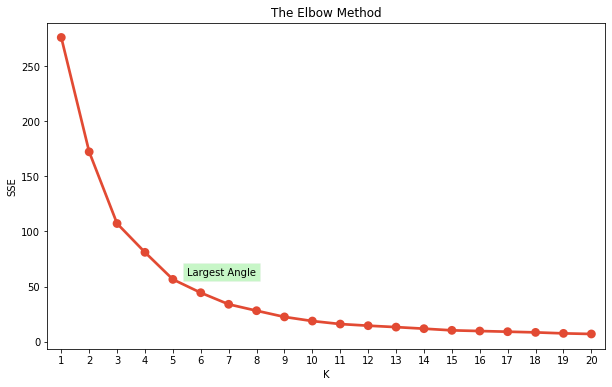

In [19]:
plt.figure(figsize=(10,6))
plt.title('The Elbow Method')

plt.xlabel('K')
plt.ylabel('SSE')
plt.style.use('ggplot')

sns.pointplot(x=list(sse.keys()), y = list(sse.values()))
plt.text(4.5, 60, "Largest Angle", bbox = dict(facecolor = 'lightgreen', alpha = 0.5))
plt.show()

In [20]:
# 5 number of clusters seems good
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(data_normalized)
cluster_labels = kmeans.labels_

data_rfm = data.assign(Cluster = cluster_labels)
data_rfm.head()

C:\Users\bramh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\bramh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Recency,Frequency,MonetaryValue,Cluster
CUSTOMERNAME,,,,
"AV Stores, Co.",196,51,157807.81,3
Alpha Cognac,65,20,70488.44,0
Amica Models & Co.,265,26,94117.26,0
"Anna's Decorations, Ltd",84,46,153996.13,3
Atelier graphique,188,7,24179.96,2
